<a href="https://colab.research.google.com/github/Khushgod/Green-Destination-Attrition-/blob/main/Green_Destination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

class AttritionAnalyzer:
    def __init__(self):
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.models = {}
        self.feature_names = None

    def load_and_explore_data(self, filepath):
        """Load dataset and perform initial exploration"""
        print("=== LOADING AND EXPLORING DATA ===")
        self.df = pd.read_csv(filepath)

        print(f"Dataset shape: {self.df.shape}")
        print(f"\nAttrition distribution:")
        print(self.df['Attrition'].value_counts())
        print(f"Attrition rate: {(self.df['Attrition'] == 'Yes').mean():.2%}")

        # Check for missing values
        missing = self.df.isnull().sum()
        if missing.any():
            print(f"\nMissing values:\n{missing[missing > 0]}")
        else:
            print("\nNo missing values found!")

        return self.df.head()

    def data_preprocessing(self):
        """Clean and preprocess the data"""
        print("\n=== DATA PREPROCESSING ===")

        # Remove constant columns
        constant_cols = []
        for col in self.df.columns:
            if self.df[col].nunique() <= 1:
                constant_cols.append(col)

        if constant_cols:
            print(f"Removing constant columns: {constant_cols}")
            self.df = self.df.drop(constant_cols, axis=1)

        # Encode target variable
        self.df['Attrition'] = (self.df['Attrition'] == 'Yes').astype(int)

        # Separate features and target
        X = self.df.drop('Attrition', axis=1)
        y = self.df['Attrition']

        # Handle categorical variables
        categorical_cols = X.select_dtypes(include=['object']).columns
        print(f"Categorical columns to encode: {list(categorical_cols)}")

        # Label encode categorical variables
        label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le

        self.feature_names = X.columns.tolist()

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale numerical features
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        self.X_train_scaled = self.X_train.copy()
        self.X_test_scaled = self.X_test.copy()

        self.X_train_scaled[numerical_cols] = self.scaler.fit_transform(self.X_train[numerical_cols])
        self.X_test_scaled[numerical_cols] = self.scaler.transform(self.X_test[numerical_cols])

        print(f"Training set size: {self.X_train.shape}")
        print(f"Test set size: {self.X_test.shape}")

    def train_models(self):
        """Train multiple models and compare performance"""
        print("\n=== TRAINING MODELS ===")

        # Define models
        models_to_try = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }

        results = {}

        for name, model in models_to_try.items():
            print(f"\nTraining {name}...")

            # Use scaled data for Logistic Regression, original for Random Forest
            if name == 'Logistic Regression':
                X_train_use = self.X_train_scaled
                X_test_use = self.X_test_scaled
            else:
                X_train_use = self.X_train
                X_test_use = self.X_test

            # Train model
            model.fit(X_train_use, self.y_train)

            # Predictions
            y_pred = model.predict(X_test_use)
            y_pred_proba = model.predict_proba(X_test_use)[:, 1]

            # Metrics
            auc_score = roc_auc_score(self.y_test, y_pred_proba)
            cv_scores = cross_val_score(model, X_train_use, self.y_train, cv=5, scoring='roc_auc')

            results[name] = {
                'model': model,
                'auc': auc_score,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }

            print(f"Test AUC: {auc_score:.3f}")
            print(f"CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

        # Store best model
        best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
        self.best_model = results[best_model_name]['model']
        self.best_model_name = best_model_name
        self.models = results

        print(f"\nBest model: {best_model_name} (AUC: {results[best_model_name]['auc']:.3f})")

    def analyze_feature_importance(self):
        """Analyze which features are most important for predicting attrition"""
        print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

        # Get feature importance from best model
        if hasattr(self.best_model, 'feature_importances_'):
            importances = self.best_model.feature_importances_
        elif hasattr(self.best_model, 'coef_'):
            importances = abs(self.best_model.coef_[0])
        else:
            print("Cannot extract feature importance from this model")
            return

        # Create feature importance dataframe
        feature_imp = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print("Top 15 Most Important Features:")
        print(feature_imp.head(15).to_string(index=False))

        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_imp.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Features - {self.best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        return feature_imp

    def turnover_factor_analysis(self):
        """Analyze factors contributing to employee turnover"""
        print("\n=== TURNOVER FACTOR ANALYSIS ===")

        # Separate attrition vs retention groups
        left = self.df[self.df['Attrition'] == 1]
        stayed = self.df[self.df['Attrition'] == 0]

        print(f"Employees who left: {len(left)}")
        print(f"Employees who stayed: {len(stayed)}")

        # Key numerical comparisons
        numerical_cols = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole',
                         'YearsSinceLastPromotion', 'DistanceFromHome', 'TotalWorkingYears']

        print("\n--- NUMERICAL FACTOR ANALYSIS ---")
        comparison_stats = []

        for col in numerical_cols:
            if col in self.df.columns:
                left_mean = left[col].mean()
                stayed_mean = stayed[col].mean()
                difference = left_mean - stayed_mean
                comparison_stats.append({
                    'Factor': col,
                    'Left_Avg': round(left_mean, 2),
                    'Stayed_Avg': round(stayed_mean, 2),
                    'Difference': round(difference, 2)
                })

        comp_df = pd.DataFrame(comparison_stats)
        print(comp_df.to_string(index=False))

        # Categorical factor analysis
        print("\n--- CATEGORICAL FACTOR ANALYSIS ---")
        categorical_cols = ['OverTime', 'BusinessTravel', 'Department', 'JobRole', 'MaritalStatus']

        for col in categorical_cols:
            if col in self.df.columns:
                attrition_rate = self.df.groupby(col)['Attrition'].agg(['count', 'sum', 'mean'])
                attrition_rate.columns = ['Total_Employees', 'Left', 'Attrition_Rate']
                attrition_rate = attrition_rate.sort_values('Attrition_Rate', ascending=False)
                print(f"\n{col} - Attrition Rates:")
                print(attrition_rate.round(3))

        # Satisfaction scores analysis
        satisfaction_cols = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'RelationshipSatisfaction']

        print("\n--- SATISFACTION ANALYSIS ---")
        for col in satisfaction_cols:
            if col in self.df.columns:
                sat_analysis = self.df.groupby(col)['Attrition'].agg(['count', 'mean'])
                sat_analysis.columns = ['Count', 'Attrition_Rate']
                print(f"\n{col}:")
                print(sat_analysis.round(3))

    def create_visualizations(self):
        """Create key visualizations for attrition analysis"""
        print("\n=== CREATING VISUALIZATIONS ===")

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Attrition by OverTime
        if 'OverTime' in self.df.columns:
            overtime_attrition = self.df.groupby('OverTime')['Attrition'].mean()
            axes[0,0].bar(overtime_attrition.index, overtime_attrition.values)
            axes[0,0].set_title('Attrition Rate by Overtime')
            axes[0,0].set_ylabel('Attrition Rate')

        # 2. Attrition by Age groups
        self.df['AgeGroup'] = pd.cut(self.df['Age'], bins=[0, 30, 40, 50, 100],
                                    labels=['<30', '30-40', '40-50', '50+'])
        age_attrition = self.df.groupby('AgeGroup')['Attrition'].mean()
        axes[0,1].bar(range(len(age_attrition)), age_attrition.values)
        axes[0,1].set_xticks(range(len(age_attrition)))
        axes[0,1].set_xticklabels(age_attrition.index)
        axes[0,1].set_title('Attrition Rate by Age Group')
        axes[0,1].set_ylabel('Attrition Rate')

        # 3. Attrition by Job Satisfaction
        if 'JobSatisfaction' in self.df.columns:
            job_sat_attrition = self.df.groupby('JobSatisfaction')['Attrition'].mean()
            axes[1,0].bar(job_sat_attrition.index, job_sat_attrition.values)
            axes[1,0].set_title('Attrition Rate by Job Satisfaction')
            axes[1,0].set_xlabel('Job Satisfaction Level')
            axes[1,0].set_ylabel('Attrition Rate')

        # 4. Monthly Income distribution
        if 'MonthlyIncome' in self.df.columns:
            axes[1,1].hist(self.df[self.df['Attrition']==0]['MonthlyIncome'],
                          alpha=0.7, label='Stayed', bins=30)
            axes[1,1].hist(self.df[self.df['Attrition']==1]['MonthlyIncome'],
                          alpha=0.7, label='Left', bins=30)
            axes[1,1].set_title('Monthly Income Distribution')
            axes[1,1].set_xlabel('Monthly Income')
            axes[1,1].set_ylabel('Frequency')
            axes[1,1].legend()

        plt.tight_layout()
        plt.show()

    def model_evaluation(self):
        """Detailed model evaluation and performance metrics"""
        print("\n=== MODEL EVALUATION ===")

        # Classification report
        best_predictions = self.models[self.best_model_name]['predictions']
        print(f"\nClassification Report - {self.best_model_name}:")
        print(classification_report(self.y_test, best_predictions))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, best_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        # ROC Curve
        plt.figure(figsize=(8, 6))
        for name, results in self.models.items():
            fpr, tpr, _ = roc_curve(self.y_test, results['probabilities'])
            plt.plot(fpr, tpr, label=f"{name} (AUC = {results['auc']:.3f})")

        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.show()

    def hyperparameter_tuning(self):
        """Perform hyperparameter tuning on the best model"""
        print("\n=== HYPERPARAMETER TUNING ===")

        if self.best_model_name == 'Random Forest':
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
            X_use = self.X_train
        else:  # Logistic Regression
            param_grid = {
                'C': [0.1, 1, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }
            X_use = self.X_train_scaled

        grid_search = GridSearchCV(
            self.best_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
        )

        grid_search.fit(X_use, self.y_train)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.3f}")

        # Update best model
        self.best_model = grid_search.best_estimator_

        return grid_search.best_estimator_

    def generate_insights(self):
        """Generate actionable insights for HR"""
        print("\n=== ACTIONABLE INSIGHTS FOR HR ===")

        insights = []

        # Overtime analysis
        if 'OverTime' in self.df.columns:
            overtime_attrition = self.df.groupby('OverTime')['Attrition'].mean()
            if 'Yes' in overtime_attrition.index and overtime_attrition['Yes'] > overtime_attrition.get('No', 0):
                insights.append(f"🚨 CRITICAL: Employees working overtime have {overtime_attrition['Yes']:.1%} attrition rate vs {overtime_attrition.get('No', 0):.1%} for non-overtime workers")

        # Satisfaction analysis
        satisfaction_cols = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance']
        for col in satisfaction_cols:
            if col in self.df.columns:
                low_satisfaction = self.df[self.df[col] <= 2]['Attrition'].mean()
                high_satisfaction = self.df[self.df[col] >= 4]['Attrition'].mean()
                if low_satisfaction > high_satisfaction:
                    insights.append(f"📊 {col}: Low satisfaction (≤2) shows {low_satisfaction:.1%} attrition vs {high_satisfaction:.1%} for high satisfaction (≥4)")

        # Age analysis
        young_attrition = self.df[self.df['Age'] < 30]['Attrition'].mean()
        older_attrition = self.df[self.df['Age'] >= 40]['Attrition'].mean()
        if young_attrition > older_attrition:
            insights.append(f"👥 AGE FACTOR: Younger employees (<30) have {young_attrition:.1%} attrition vs {older_attrition:.1%} for older employees (40+)")

        # Income analysis
        if 'MonthlyIncome' in self.df.columns:
            income_quartiles = pd.qcut(self.df['MonthlyIncome'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
            income_attrition = self.df.groupby(income_quartiles)['Attrition'].mean()
            if income_attrition['Q1'] > income_attrition['Q4']:
                insights.append(f"💰 COMPENSATION: Lowest income quartile has {income_attrition['Q1']:.1%} attrition vs {income_attrition['Q4']:.1%} for highest quartile")

        # Print insights
        for i, insight in enumerate(insights, 1):
            print(f"{i}. {insight}")

        # Recommendations
        print("\n=== RECOMMENDATIONS ===")
        recommendations = [
            "🎯 Focus retention efforts on employees with low job satisfaction scores",
            "⏰ Review overtime policies and workload distribution",
            "💼 Implement targeted retention programs for younger employees",
            "📈 Consider compensation reviews for lower-paid employees",
            "🏢 Improve work environment satisfaction through employee feedback",
            "⚖️ Promote better work-life balance initiatives",
            "📊 Monitor satisfaction scores regularly and intervene early"
        ]

        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")

    def predict_attrition_risk(self, employee_data=None):
        """Predict attrition risk for new employees"""
        print("\n=== ATTRITION RISK PREDICTION ===")

        if employee_data is None:
            # Create sample predictions using test set
            probabilities = self.models[self.best_model_name]['probabilities']
            high_risk_indices = np.where(probabilities > 0.7)[0]

            print(f"High-risk employees in test set: {len(high_risk_indices)}")
            print("Sample high-risk employees:")

            for i in high_risk_indices[:5]:  # Show first 5
                risk_score = probabilities[i]
                print(f"Employee {i+1}: {risk_score:.1%} risk")

        return probabilities

    def run_complete_analysis(self, filepath):
        """Run the complete attrition analysis pipeline"""
        print("🚀 STARTING COMPLETE EMPLOYEE ATTRITION ANALYSIS")
        print("="*60)

        # Step 1: Load and explore
        self.load_and_explore_data(filepath)

        # Step 2: Preprocess data
        self.data_preprocessing()

        # Step 3: Train models
        self.train_models()

        # Step 4: Hyperparameter tuning
        self.hyperparameter_tuning()

        # Step 5: Model evaluation
        self.model_evaluation()

        # Step 6: Feature importance
        feature_importance = self.analyze_feature_importance()

        # Step 7: Turnover analysis
        self.turnover_factor_analysis()

        # Step 8: Create visualizations
        self.create_visualizations()

        # Step 9: Generate insights
        self.generate_insights()

        # Step 10: Risk prediction
        self.predict_attrition_risk()

        print("\n✅ ANALYSIS COMPLETE!")
        print("="*60)

        return {
            'best_model': self.best_model,
            'feature_importance': feature_importance,
            'model_performance': self.models
        }


🚀 STARTING COMPLETE EMPLOYEE ATTRITION ANALYSIS
=== LOADING AND EXPLORING DATA ===
Dataset shape: (1470, 35)

Attrition distribution:
Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition rate: 16.12%

No missing values found!

=== DATA PREPROCESSING ===
Removing constant columns: ['EmployeeCount', 'Over18', 'StandardHours']
Categorical columns to encode: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Training set size: (1176, 31)
Test set size: (294, 31)

=== TRAINING MODELS ===

Training Random Forest...
Test AUC: 0.765
CV AUC: 0.772 (+/- 0.091)

Training Logistic Regression...
Test AUC: 0.805
CV AUC: 0.806 (+/- 0.109)

Best model: Logistic Regression (AUC: 0.805)

=== HYPERPARAMETER TUNING ===
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.806

=== MODEL EVALUATION ===

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

          

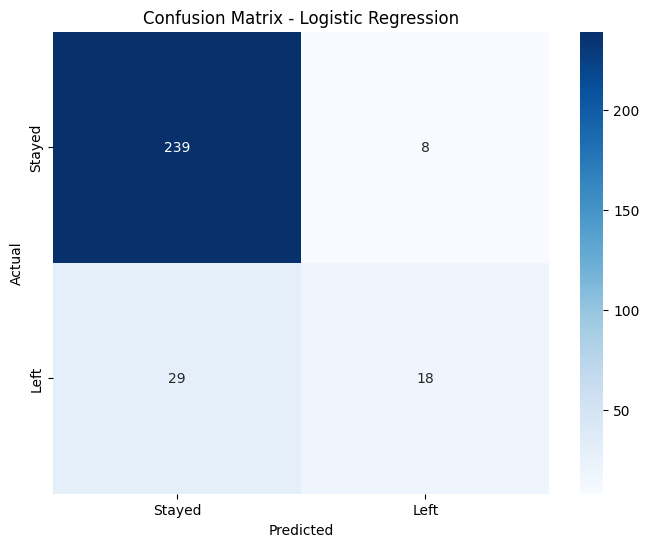

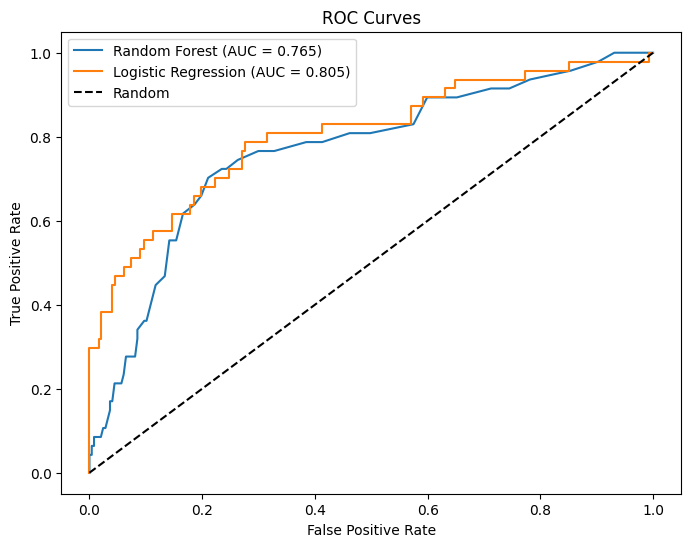


=== FEATURE IMPORTANCE ANALYSIS ===
Top 15 Most Important Features:
                feature  importance
               OverTime    0.770936
YearsSinceLastPromotion    0.471007
             Department    0.460285
     NumCompaniesWorked    0.442547
EnvironmentSatisfaction    0.430869
   YearsWithCurrManager    0.428145
      TotalWorkingYears    0.412412
                    Age    0.404397
        JobSatisfaction    0.375577
     YearsInCurrentRole    0.351810
         JobInvolvement    0.342932
       DistanceFromHome    0.308687
          MaritalStatus    0.289819
       StockOptionLevel    0.277982
                JobRole    0.264386


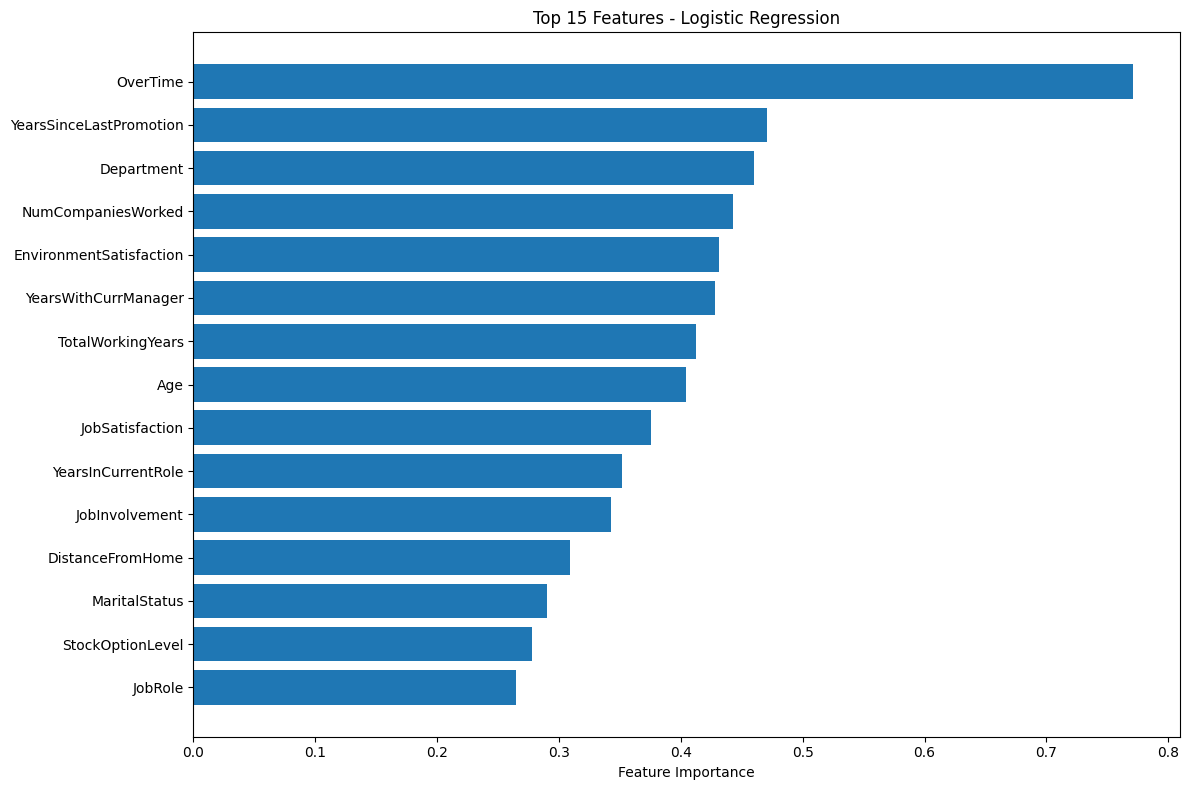


=== TURNOVER FACTOR ANALYSIS ===
Employees who left: 237
Employees who stayed: 1233

--- NUMERICAL FACTOR ANALYSIS ---
                 Factor  Left_Avg  Stayed_Avg  Difference
                    Age     33.61       37.56       -3.95
          MonthlyIncome   4787.09     6832.74    -2045.65
         YearsAtCompany      5.13        7.37       -2.24
     YearsInCurrentRole      2.90        4.48       -1.58
YearsSinceLastPromotion      1.95        2.23       -0.29
       DistanceFromHome     10.63        8.92        1.72
      TotalWorkingYears      8.24       11.86       -3.62

--- CATEGORICAL FACTOR ANALYSIS ---

OverTime - Attrition Rates:
          Total_Employees  Left  Attrition_Rate
OverTime                                       
Yes                   416   127           0.305
No                   1054   110           0.104

BusinessTravel - Attrition Rates:
                   Total_Employees  Left  Attrition_Rate
BusinessTravel                                          
Travel_Fr

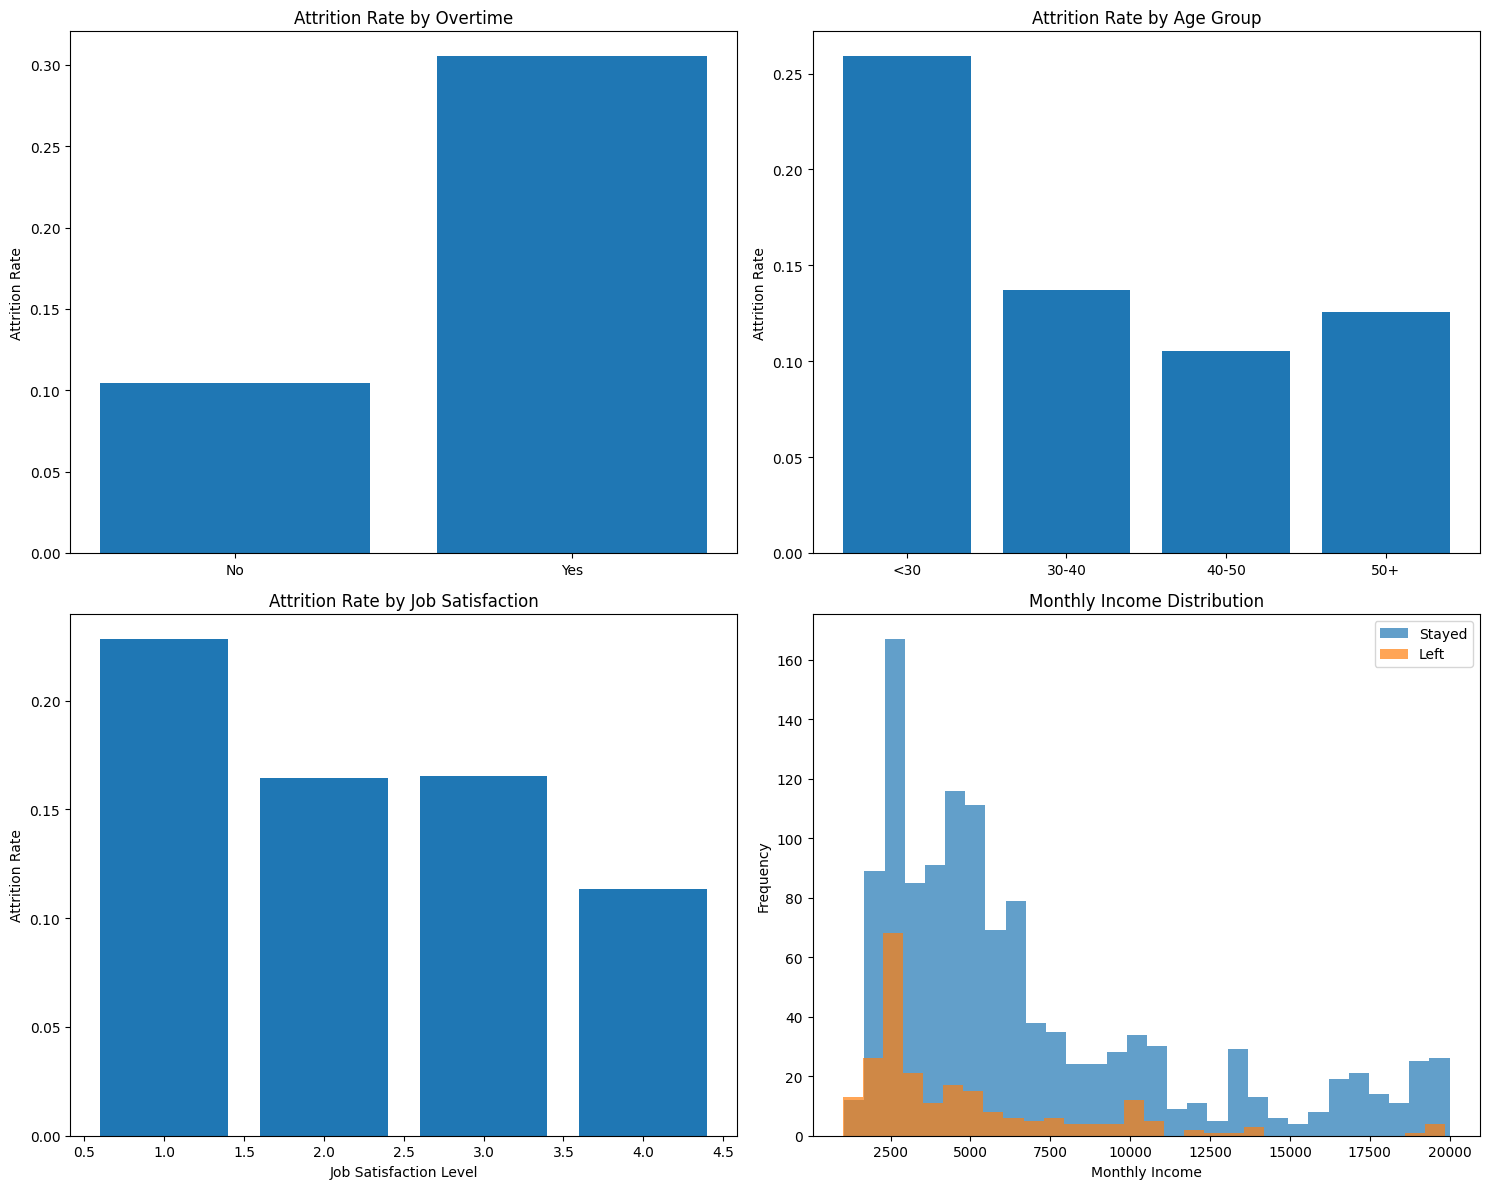


=== ACTIONABLE INSIGHTS FOR HR ===
1. 🚨 CRITICAL: Employees working overtime have 30.5% attrition rate vs 10.4% for non-overtime workers
2. 📊 JobSatisfaction: Low satisfaction (≤2) shows 19.7% attrition vs 11.3% for high satisfaction (≥4)
3. 📊 EnvironmentSatisfaction: Low satisfaction (≤2) shows 20.1% attrition vs 13.5% for high satisfaction (≥4)
4. 📊 WorkLifeBalance: Low satisfaction (≤2) shows 19.6% attrition vs 17.6% for high satisfaction (≥4)
5. 👥 AGE FACTOR: Younger employees (<30) have 27.9% attrition vs 10.9% for older employees (40+)
6. 💰 COMPENSATION: Lowest income quartile has 29.3% attrition vs 10.3% for highest quartile

=== RECOMMENDATIONS ===
1. 🎯 Focus retention efforts on employees with low job satisfaction scores
2. ⏰ Review overtime policies and workload distribution
3. 💼 Implement targeted retention programs for younger employees
4. 📈 Consider compensation reviews for lower-paid employees
5. 🏢 Improve work environment satisfaction through employee feedback
6. ⚖️ Pro

In [2]:
analyzer = AttritionAnalyzer()
results = analyzer.run_complete_analysis('greendestination (1) (1).csv')